In [1]:
import os
os.environ["PKG_CONFIG_PATH"] = "/home/jaeyonglee/anaconda3/envs/fenics/lib/pkgconfig"

In [2]:
import numpy as np
import scipy
from scipy import io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import torch

In [3]:
import dolfin
from dolfin import *
from mshr import *

### 1D Convection-diffusion equation with variable coefficient input

#### Learning the solution operator $\mathcal{G}:c(x)\mapsto u(x)$ for
##### $-\epsilon u_{xx}+b(x)u_x+c(x)u=f(x)$, $x\in[-1,1]$,
##### $u(x)=0$, $x\in\{-1,1\}$
##### with $\epsilon=0.1$ and $b(x)=x^2+1$.

Setting num :32 // Num Element : 32


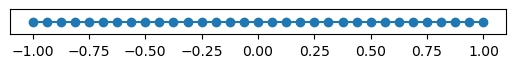

In [4]:
num_x=32
mesh = IntervalMesh(num_x,-1,1)
plot(mesh)
print("Setting num :{} // Num Element : {}".format(num_x, mesh.cells().shape[0]))

In [5]:
def fenics_mesh(num_x, num_input, deg_v, deg_f=5):
  mesh = IntervalMesh(num_x,-1,1)
  V = FunctionSpace(mesh, "Lagrange", deg_v)
  bold_v = Expression('x[0]*x[0] +1', degree=deg_f)
  bc = DirichletBC(V, 0, 'on_boundary')

  u = TrialFunction(V)
  v = TestFunction(V)

  a = u.dx(0)*v.dx(0)*dx
  A = PETScMatrix()
  A = assemble(a)
  bc.apply(A)
  stiff = A.array()

  c = (bold_v*u.dx(0))*v*dx
  C = PETScMatrix()
  C = assemble(c)
  bc.apply(C)
  convection = C.array()

  f = Constant(1)
  l = f*v*dx
  L = assemble(l)
  bc.apply(L)
  load_vector = L.get_local()

  train_coeff_inputs=[]
  train_matrix=[]
  np.random.seed(5)
  for i in range(num_input[0]):
    m0, m1 = 1 + 2*np.random.rand(2)
    n0, n1= 2*np.pi*(np.random.rand(2))
    input = Expression('m0*sin(n0*x[0]) + m1*cos(n1*x[0])', degree=deg_f, m0=m0,m1=m1,n0=n0,n1=n1)
    lin = input*u*v*dx
    LIN = assemble(lin)
    bc.apply(LIN)
    input_matrix = LIN.array()
    train_coeff_inputs.append(np.array([m0, m1, n0, n1]))
    train_matrix.append(input_matrix)

  validate_coeff_inputs=[]
  validate_matrix=[]
  np.random.seed(10)
  for i in range(num_input[1]):
    m0, m1 = 1 + 2*np.random.rand(2)
    n0, n1= 2*np.pi*(np.random.rand(2))
    input = Expression('m0*sin(n0*x[0]) + m1*cos(n1*x[0])', degree=deg_f, m0=m0,m1=m1,n0=n0,n1=n1)
    lin = input*u*v*dx
    LIN = assemble(lin)
    bc.apply(LIN)
    input_matrix = LIN.array()
    validate_coeff_inputs.append(np.array([m0, m1, n0, n1]))
    validate_matrix.append(input_matrix)

  ne=mesh.cells().shape[0]
  dofmap = V.dofmap()
  p = V.tabulate_dof_coordinates().reshape(-1)
  ng = p.shape[0]

  c=[]
  for i in range(ne):
    c.append(dofmap.cell_dofs(i))
  c=np.asarray(c)

  idx_bdry_pts=list(bc.get_boundary_values().keys())
  idx_bdry_pts
  
  gfl = np.zeros((ng))
  gfl[idx_bdry_pts]=1

  print("Num of Elements : {}, Num of points : {}".format(ne, ng))
  return ne, ng, p, c, gfl, stiff, convection, load_vector, np.array(train_coeff_inputs), np.array(train_matrix), np.array(validate_coeff_inputs), np.array(validate_matrix)


In [6]:
order=2
list_ne=[32, 300]
num_input=[1000, 1000]
typ='varcoeff'

In [7]:
for idx, ne in enumerate(list_ne):
  ne, ng, p, c, gfl, stiff, convection, load_vector, train_coeff_inputs, train_matrix, validate_coeff_inputs, validate_matrix=fenics_mesh(ne, num_input, deg_v=order)
  np.savez('mesh/P{}_ne{}_{}.npz'.format(order,list_ne[idx], typ),ne=ne,ng=ng,p=p,c=c,gfl=gfl,stiff=stiff,convection=convection,load_vector=load_vector,train_coeff_inputs=train_coeff_inputs, train_matrix=train_matrix, validate_coeff_inputs=validate_coeff_inputs, validate_matrix=validate_matrix)

Num of Elements : 32, Num of points : 65
Num of Elements : 300, Num of points : 601


In [8]:
def fenics_data(num_x, num_input, deg_v, deg_f=5):
  # Set solver parameters to suppress output
  parameters["std_out_all_processes"] = False  # Suppress output for parallel runs
  set_log_level(LogLevel.ERROR)  # Suppress solver logs
  
  train_fenics_u=[]
  np.random.seed(5)
  for i in range(num_input[0]):
    mesh = IntervalMesh(num_x,-1,1)
    V = FunctionSpace(mesh, "Lagrange", deg_v)
    EPS = Constant(0.1)
    bold_v = Expression('x[0]*x[0] +1', degree=deg_f)
    bc = DirichletBC(V, 0, 'on_boundary')

    u = TrialFunction(V)
    v = TestFunction(V)

    a = u.dx(0)*v.dx(0)*dx
    c = (bold_v*u.dx(0))*v*dx

    m0, m1 = 1 + 2*np.random.rand(2)
    n0, n1= 2*np.pi*(np.random.rand(2))
    input = Expression('m0*sin(n0*x[0]) + m1*cos(n1*x[0])', degree=deg_f, m0=m0,m1=m1,n0=n0,n1=n1)
    lin = input*u*v*dx

    f = Constant(1)
    l = f*v*dx

    u = Function(V)
    solve(EPS*a+c+lin == l, u, bc)
    fenics_u = u.vector().get_local()

    p = V.tabulate_dof_coordinates().reshape(-1)
    train_fenics_u.append([fenics_u, m0*np.sin(n0*p) + m1*np.cos(n1*p), np.array([m0, m1, n0, n1])])

  validate_fenics_u=[]
  np.random.seed(10)
  for i in range(num_input[1]):
    mesh = IntervalMesh(num_x,-1,1)
    V = FunctionSpace(mesh, "Lagrange", deg_v)
    EPS = Constant(0.1)
    bold_v = Expression('x[0]*x[0] +1', degree=deg_f)
    bc = DirichletBC(V, 0, 'on_boundary')

    u = TrialFunction(V)
    v = TestFunction(V)

    a = u.dx(0)*v.dx(0)*dx
    c = (bold_v*u.dx(0))*v*dx

    m0, m1 = 1 + 2*np.random.rand(2)
    n0, n1= 2*np.pi*(np.random.rand(2))
    input = Expression('m0*sin(n0*x[0]) + m1*cos(n1*x[0])', degree=deg_f, m0=m0,m1=m1,n0=n0,n1=n1)
    lin = input*u*v*dx

    f = Constant(1)
    l = f*v*dx

    u = Function(V)
    solve(EPS*a+c+lin == l, u, bc)
    fenics_u = u.vector().get_local()

    p = V.tabulate_dof_coordinates().reshape(-1)
    validate_fenics_u.append([fenics_u, m0*np.sin(n0*p) + m1*np.cos(n1*p), np.array([m0, m1, n0, n1])])

  return np.array(train_fenics_u, dtype=object), np.array(validate_fenics_u, dtype=object)


In [9]:
order=2
list_ne=[300]
num_input=[1000, 1000]
typ='varcoeff'

In [10]:
import pickle
for idx, ne in enumerate(list_ne):
  train_fenics_u,validate_fenics_u = fenics_data(ne, num_input, deg_v=order)
  with open('data/train_P{}_{}N{}_{}.pkl'.format(order,num_input[0],list_ne[idx],typ), 'wb') as f:
        pickle.dump(train_fenics_u, f, pickle.HIGHEST_PROTOCOL)
  with open('data/validate_P{}_{}N{}_{}.pkl'.format(order,num_input[1],list_ne[idx],typ), 'wb') as f:
        pickle.dump(validate_fenics_u, f, pickle.HIGHEST_PROTOCOL)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
